<a href="https://colab.research.google.com/github/randreove/TS/blob/main/notebooks/60_Forecasting%20II%20Deep%20Learning/4_Data%20Scaling/B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling LSTM with Scaled Data

## Load Dataset

In [1]:
import pandas as pd
df = pd.read_csv('/content/precio_mercado_diario.csv', parse_dates=['datetime_utc'], index_col=0)
df = df.loc["2020":].copy()
df

,Mercado SPOT
datetime_utc,
2020-01-01 00:00:00+00:00,38.60
2020-01-01 01:00:00+00:00,36.55
2020-01-01 02:00:00+00:00,32.32
2020-01-01 03:00:00+00:00,30.85
2020-01-01 04:00:00+00:00,30.14
...,...
2023-08-04 17:00:00+00:00,70.00
2023-08-04 18:00:00+00:00,86.30
2023-08-04 19:00:00+00:00,94.00


## Data Preprocessing

### Scale Data

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(df)

### Train Test Split

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_norm, test_size=0.2, shuffle=False)

### Create Sequences

In [4]:
import numpy as np

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24 # Use 24 hours prior to predict the following hour
X_train, y_train = create_sequences(train, sequence_length)
X_test, y_test = create_sequences(test, sequence_length)

## Modelling

### Design NN Architecture

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

model = Sequential(layers=[
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

### Train Model

In [6]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    X_train, y_train, epochs=50, batch_size=64, verbose=0,
    validation_data=(X_test, y_test), callbacks=[early_stop])

### Calculate Predictions

In [7]:
y_pred = model.predict(X_test)
y_pred

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0.17007719],
       [0.13363802],
       [0.11707989],
       ...,
       [0.12952581],
       [0.13384324],
       [0.12917988]], dtype=float32)

### Evaluate Model

In [8]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred, squared=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.015792887896843678

### Comparison: Real Data & Prediction

#### Descale Data

In [9]:
y_pred_scaled_inverse = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y_test)

#### Create DataFrame

In [ ]:
import sys
sys.path.append('../')

In [ ]:
import utils

dic_pred = {
    'y_pred': y_pred,
    'y_pred_scaled_inverse': y_pred_scaled_inverse,
}

df_pred = utils.process_df_pred(df, y_test, dic_pred)
df_pred

/Users/sota/Library/CloudStorage/Dropbox/2 Business/1 Datons/2 Areas/Courses/22 TS/solutions-new/notebooks/60_Forecasting II Deep Learning/4_Data Scaling/../utils.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=date_start, end=date_end, freq='H')


,y_true,y_pred,y_pred_scaled_inverse
2022-11-15 22:00:00+00:00,0.150000,0.173806,121.664383
2022-11-15 23:00:00+00:00,0.129314,0.138623,97.036171
...,...,...,...
2023-08-04 20:00:00+00:00,0.134286,0.134947,94.463051
2023-08-04 21:00:00+00:00,0.131000,0.130350,91.244682


In [10]:
def process_df_pred(df, y_true, dic_pred):
    """
    Toma un DataFrame original con un índice de fechas más amplio, los valores reales de y_test
    y un diccionario de predicciones. Devuelve un DataFrame con el índice de fechas correspondiente
    a los valores de y_true y las predicciones.

    Parámetros:
    - df: DataFrame original con un índice de fechas.
    - y_true: Serie o array de valores reales (y_test).
    - dic_pred: Diccionario con predicciones, donde la clave es el nombre del modelo y el valor es la Serie o array de predicciones.

    Retorna:
    - DataFrame con el índice de fechas y columnas de valores reales y predicciones.
    """
    # Asegurarse de que y_true sea 1D
    if len(y_true.shape) > 1:
        y_true = y_true.ravel()

    # Asegurar que cada predicción en dic_pred sea 1D
    for model_name in dic_pred:
        if len(dic_pred[model_name].shape) > 1:
            dic_pred[model_name] = dic_pred[model_name].ravel()

    # Suponemos que y_true y dic_pred tienen un índice que coincide con una parte del índice de df
    common_index = df.index[-len(y_true):]  # Toma las últimas posiciones para que coincidan con y_true

    # Crear un DataFrame base con el índice común y y_true
    df_result = pd.DataFrame(index=common_index, data={'y_true': y_true})

    # Añadir las predicciones al DataFrame
    for model_name, pred in dic_pred.items():
        df_result[model_name] = pred

    return df_result

# Ejemplo de uso:
# resultado = process_df_pred(df, y_test, dic_pred)

In [16]:
dic_pred = {
    'y_pred': y_pred,
    'y_pred_scaled_inverse': y_pred_scaled_inverse,
}

df_pred = process_df_pred(df, y_true=y_true, dic_pred=dic_pred)

# df_pred = y_test.copy()
df_pred

,y_true,y_pred,y_pred_scaled_inverse
datetime_utc,,,
2022-11-15 22:00:00+00:00,105.00,0.170077,119.054031
2022-11-15 23:00:00+00:00,90.52,0.133638,93.546616
2022-11-16 00:00:00+00:00,87.00,0.117080,81.955925
2022-11-16 01:00:00+00:00,85.00,0.115614,80.929520
2022-11-16 02:00:00+00:00,84.92,0.115985,81.189407
...,...,...,...
2023-08-04 17:00:00+00:00,70.00,0.078661,55.062420
2023-08-04 18:00:00+00:00,86.30,0.111681,78.176674
2023-08-04 19:00:00+00:00,94.00,0.129526,90.668068


#### Evaluate Model

In [17]:
mean_squared_error(df_pred.y_true, df_pred.y_pred_scaled_inverse, squared=False)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


11.055021505174352

#### Visualize Data

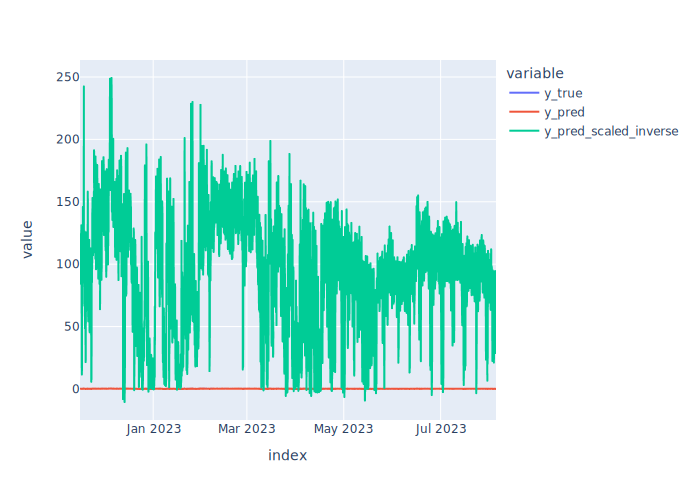

In [ ]:
utils.plot_df(df_pred)

In [14]:
import matplotlib.pyplot as plt

def plot_predictions(df_pred):
    """
    Genera una gráfica de los valores reales y las predicciones.

    Parámetros:
    - df_pred: DataFrame que contiene la columna 'y_true' con los valores reales y
               otras columnas con las predicciones de distintos modelos.
    """
    plt.figure(figsize=(14, 7))

    # Graficar la columna de valores reales
    plt.plot(df_pred.index, df_pred['y_true'], label='Valores Reales (y_test)', linewidth=2, color='red')

    # Graficar cada columna de predicciones
    for col in df_pred.columns:
        if col != 'y_true':
            plt.plot(df_pred.index, df_pred[col], label=f'Predicción: {col}')

    plt.title('Comparación de Valores Reales y Predicciones')
    plt.xlabel('Fecha')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejemplo de uso:
# plot_predictions(df_pred)

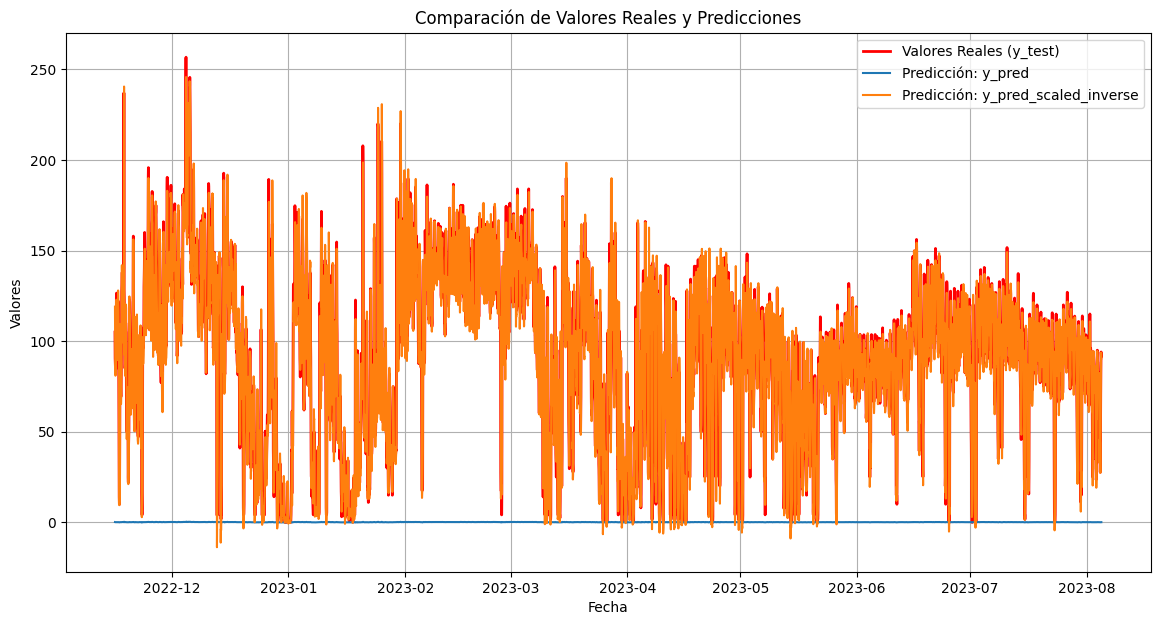

In [18]:
plot_predictions(df_pred)